<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/airways.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# Required Libraries
# For Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# For Splitting Data into Training & Testing Sets
from sklearn.model_selection import train_test_split
# For stratified k-fold partitions
from sklearn.model_selection import StratifiedKFold
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier

#from sklearn.preprocessing import OneHotEncoder # For Creating Dummy Variables of Categorical Data [Nominal]
#from sklearn.impute import SimpleImputer # For Imputation of Missing Data
#from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # For Encoding Categorical Data [Nominal | Ordinal]
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # For Rescaling Data

In [4]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [72]:
# Read data from google drive
df=pd.read_csv('/gdrive/MyDrive/Colab_data_files/drHarshVardhan/airways_mod_ver4.csv')
df.head()
df.describe()

age     sex  height  subluxation of mandible  head and neck movement  \
0   22    male     172                        1                       0   
1   55  female     143                        1                       0   
2   59    male     162                        2                       1   
3   48  female     168                        1                       0   
4   51  female     154                        3                       0   

   buck teeth  edentulous    bmi  sternomental distance  thyromental distance  \
0           1         0.0  22.40                   17.0                   8.6   
1           1         0.0  27.45                   16.0                   7.8   
2           0         1.0  24.20                   14.3                   6.9   
3           0         0.0  28.50                   15.6                   7.2   
4           0         1.0  25.30                   14.3                   6.7   

   mallampatti  mouth opening  cormack lahane  
0            2              0               1  
1            2              0               0  
2            3              0               2  
3            3              0               1  
4            4              1               3

age       height  subluxation of mandible  \
count  1000.000000  1000.000000              1000.000000   
mean     43.498000   163.035000                 0.206000   
std      11.742823    11.470804                 0.491738   
min      20.000000   132.000000                 0.000000   
25%      34.000000   155.000000                 0.000000   
50%      45.000000   163.000000                 0.000000   
75%      54.000000   171.000000                 0.000000   
max      64.000000   195.000000                 3.000000   

       head and neck movement   buck teeth  edentulous          bmi  \
count             1000.000000  1000.000000  998.000000  1000.000000   
mean                 0.104000     0.259000    0.173347    23.895350   
std                  0.305413     0.440583    0.378737     3.869877   
min                  0.000000     0.000000    0.000000    13.800000   
25%                  0.000000     0.000000    0.000000    21.400000   
50%                  0.000000     0.000000    0.000000    24.000000   
75%                  0.000000     1.000000    0.000000    26.525000   
max                  1.000000     2.000000    1.000000    37.000000   

       sternomental distance  thyromental distance  mallampatti  \
count            1000.000000           1000.000000    1000.0000   
mean               16.935400              8.101800       1.9100   
std                 1.592276              0.919566       0.6902   
min                12.500000              5.600000       1.0000   
25%                16.000000              7.500000       1.0000   
50%                17.000000              8.000000       2.0000   
75%                18.000000              8.600000       2.0000   
max                22.000000             11.000000       4.0000   

       mouth opening  cormack lahane  
count    1000.000000     1000.000000  
mean        0.010000        0.826000  
std         0.099549        0.714307  
min         0.000000        0.000000  
25%         0.000000        0.000000  
50%         0.000000        1.000000  
75%         0.000000        1.000000  
max         1.000000        3.000000

In [73]:
# Remove leading/trailing spaces
df.columns = df.columns.str.strip()
# Within a col name keep single space
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)  # Replaces multiple spaces with a single space
df.head()

age     sex  height  subluxation of mandible  head and neck movement  \
0   22    male     172                        1                       0   
1   55  female     143                        1                       0   
2   59    male     162                        2                       1   
3   48  female     168                        1                       0   
4   51  female     154                        3                       0   

   buck teeth  edentulous    bmi  sternomental distance  thyromental distance  \
0           1         0.0  22.40                   17.0                   8.6   
1           1         0.0  27.45                   16.0                   7.8   
2           0         1.0  24.20                   14.3                   6.9   
3           0         0.0  28.50                   15.6                   7.2   
4           0         1.0  25.30                   14.3                   6.7   

   mallampatti  mouth opening  cormack lahane  
0            2              0               1  
1            2              0               0  
2            3              0               2  
3            3              0               1  
4            4              1               3

In [74]:
# Map 'male' and 'female' to 0 and 1

df['sex'].value_counts()

mappings = {
            'female': 0,
            'male': 1
           }

df['sex'] = df['sex'].map(mappings)

df['sex'].value_counts()


sex
female    535
male      465
Name: count, dtype: int64

sex
0    535
1    465
Name: count, dtype: int64

In [75]:
# Distribution of target values
# Are classes balanced?
df['cormack lahane'].value_counts()

cormack lahane
1    559
0    324
2     84
3     33
Name: count, dtype: int64

In [76]:
cat_features = ['sex', 'buck teeth', 'edentulous', 'mallampatti', 'mouth opening', 'subluxation of mandible', 'head and neck movement', 'cormack lahane']
num_features = ["age", "height", "bmi", "sternomental distance", "thyromental distance"]
# Select categorical and numerical columns
df_cat = df[cat_features]
df_num = df[num_features]
df_cat.nunique()
df_cat.head()


sex                        2
buck teeth                 3
edentulous                 2
mallampatti                4
mouth opening              2
subluxation of mandible    4
head and neck movement     2
cormack lahane             4
dtype: int64

sex  buck teeth  edentulous  mallampatti  mouth opening  \
0    1           1         0.0            2              0   
1    0           1         0.0            2              0   
2    1           0         1.0            3              0   
3    0           0         0.0            3              0   
4    0           0         1.0            4              1   

   subluxation of mandible  head and neck movement  cormack lahane  
0                        1                       0               1  
1                        1                       0               0  
2                        2                       1               2  
3                        1                       0               1  
4                        3                       0               3

In [77]:
# prompt: Using dataframe df_cat: transform all features to 'category'

# Convert all columns to 'category' dtype
for col in cat_features:
    df[col] = df[col].astype('category')

# Display the updated data types
df.dtypes


age                           int64
sex                        category
height                        int64
subluxation of mandible    category
head and neck movement     category
buck teeth                 category
edentulous                 category
bmi                         float64
sternomental distance       float64
thyromental distance        float64
mallampatti                category
mouth opening              category
cormack lahane             category
dtype: object

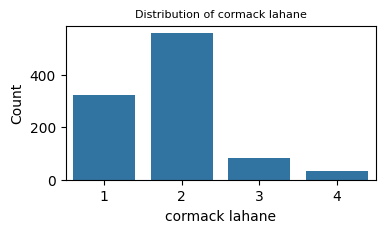

In [13]:
_=plt.figure(figsize=(4, 2))
_=sns.countplot(x='cormack lahane', data=df)
_=plt.title('Distribution of cormack lahane', fontsize = 8)
_=plt.xlabel('cormack lahane')
_=plt.ylabel('Count')
_=plt.show()


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1000 non-null   int64   
 1   sex                      1000 non-null   category
 2   height                   1000 non-null   int64   
 3   subluxation of mandible  1000 non-null   category
 4   head and neck movement   1000 non-null   category
 5   buck teeth               1000 non-null   category
 6   edentulous               998 non-null    category
 7   bmi                      1000 non-null   float64 
 8   sternomental distance    1000 non-null   float64 
 9   thyromental distance     1000 non-null   float64 
 10  mallampatti              1000 non-null   category
 11  mouth opening            1000 non-null   category
 12  cormack lahane           1000 non-null   category
dtypes: category(8), float64(3), int64(2)
memory usage: 48.2 KB


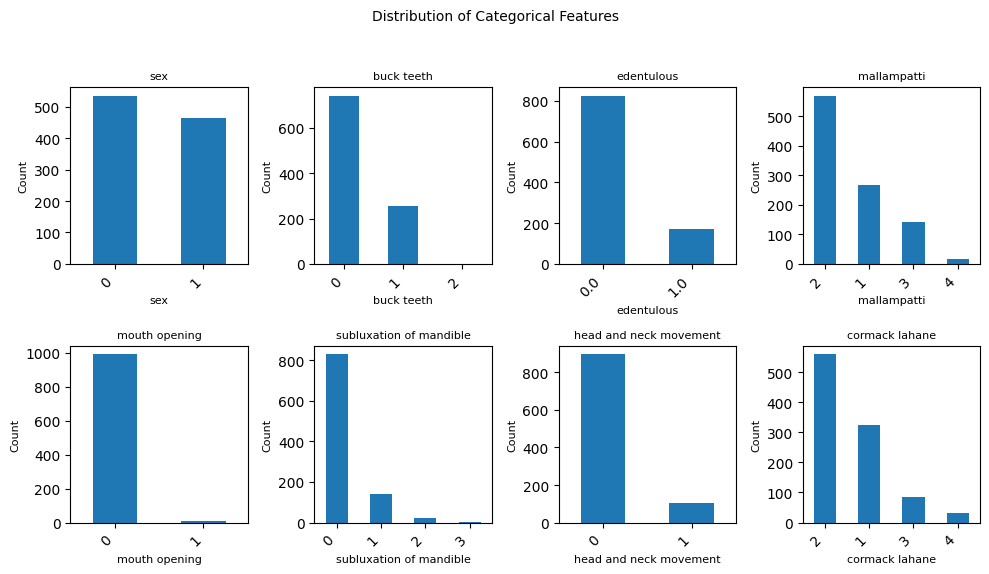

In [15]:
# prompt: Plot distributions of all features of df_cat in 2 X 4 matrix. Plot graph titles in fontsize of 8 and axis labels also in fontsize of 8. Give overall title as Distribution of Categorical Features

# Assuming df_cat is already defined as in the provided code

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
_=fig.suptitle('Distribution of Categorical Features', fontsize=10)

for i, col in enumerate(df_cat.columns):
    ax = axes[i // 4, i % 4]
    _=df_cat[col].value_counts().plot(kind='bar', ax=ax)
    _=ax.set_title(col, fontsize=8)
    _=ax.set_xlabel(col, fontsize=8)
    _=ax.set_ylabel('Count', fontsize=8)
    _=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

_=plt.tight_layout(rect=[0, 0.03, 1, 0.95])
_=plt.show()


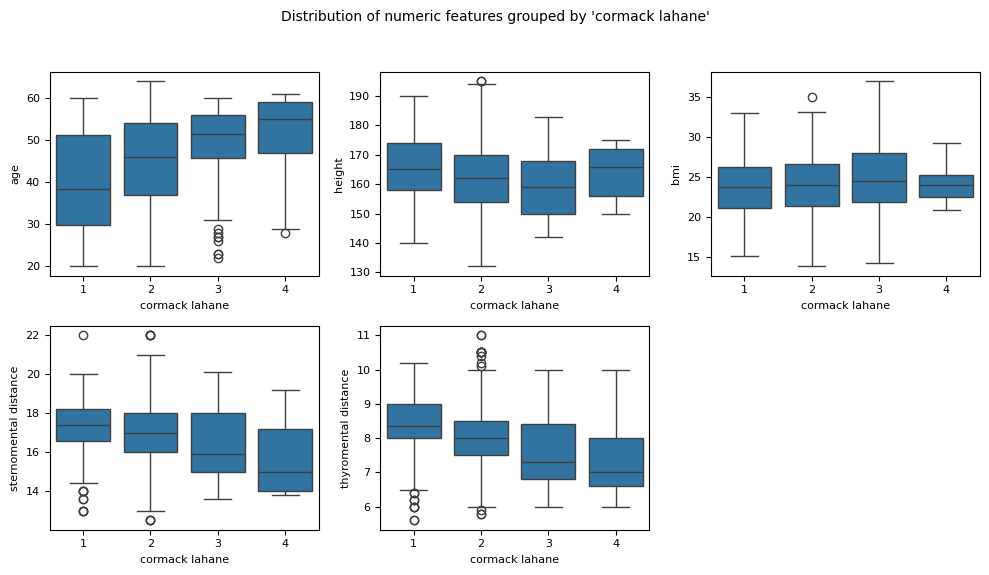

In [16]:
# prompt: Consider the dataframe df. Draw box plots of all numeric features grouped by 'cormack lahane'. Plot them in a matrix of 2 X 3.. Keep the fontsize of labels to 8. Keep overall title as distribution of numeric features grouped by  'cormack lahane'. Delete the last unused axes


fig, axes = plt.subplots(2, 3, figsize=(10, 6))
_=fig.suptitle("Distribution of numeric features grouped by 'cormack lahane'", fontsize=10)

for i, col in enumerate(df_num.columns):
    ax = axes[i // 3, i % 3]
    _=sns.boxplot(x='cormack lahane', y=col, data=df, ax=ax)
    _=ax.set_xlabel('cormack lahane', fontsize=8)
    _=ax.set_ylabel(col, fontsize=8)
    _=ax.tick_params(axis='x', labelsize=8)
    _=ax.tick_params(axis='y', labelsize=8)


# Delete the last unused axes if necessary (adjust the index based on the number of numeric features)
if len(df_num.columns) < 6:
    for i in range(len(df_num.columns), 6):
      _=axes.flatten()[i].set_visible(False)


_=plt.tight_layout(rect=[0, 0.03, 1, 0.95])
_=plt.show()


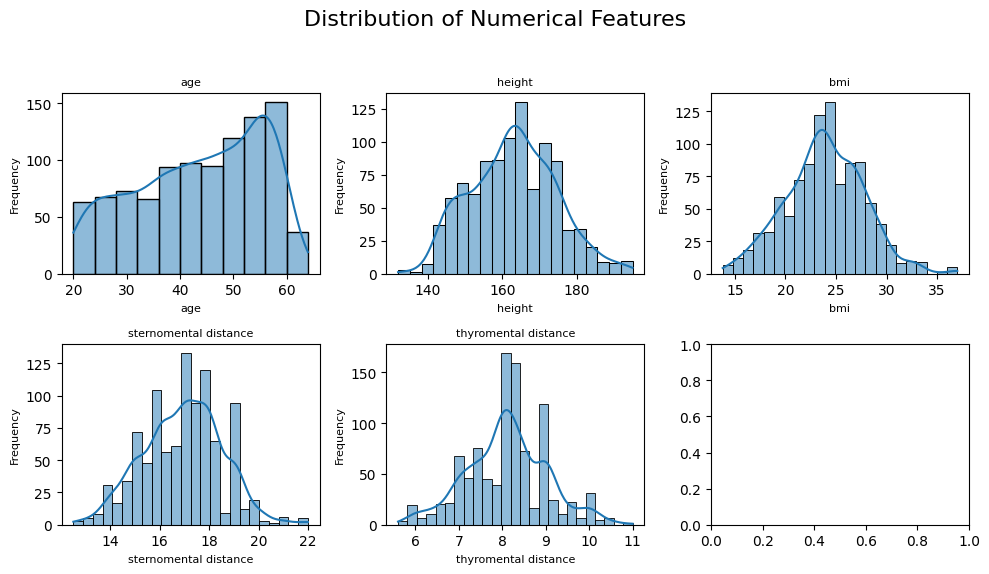

In [17]:
# prompt: Plot distribution of all features of df_num. But do not show the last  plot ie the sixth with no data ie do not show even its axis

import matplotlib.pyplot as plt
# Assuming df_num is already defined as in the provided code

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
_=fig.suptitle('Distribution of Numerical Features', fontsize=16)

for i, col in enumerate(df_num.columns):
    if i < 5:  # Skip the sixth plot
        ax = axes[i // 3, i % 3]
        _=sns.histplot(df_num[col], ax=ax, kde=True) # Use histplot for better visualization
        _=ax.set_title(col, fontsize=8)
        _=ax.set_xlabel(col, fontsize=8)
        _=ax.set_ylabel('Frequency', fontsize=8)
    elif i==5:
        ax = axes[-1,-1]
        #ax = axes[i // 3, i % 3]
        #ax.axes.set_visible(False)
        ax.axis('off') # Hide the axis of the sixth plot
        ax.axes.flatten()[i].set_visible(False)



_=plt.tight_layout(rect=[0, 0.03, 1, 0.95])
_=plt.show()


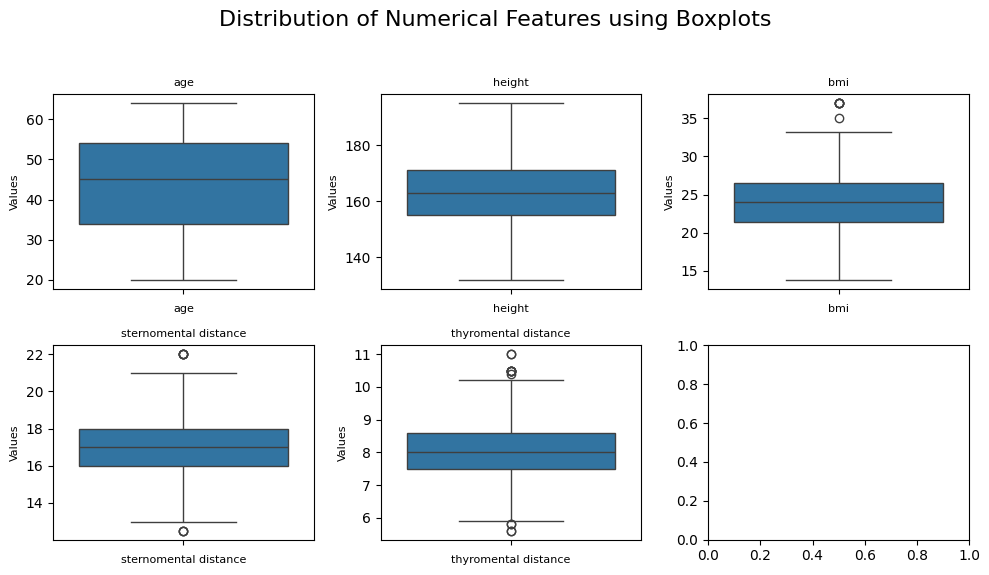

In [18]:
# prompt: Plot distribution of all features of df_num using boxplots.

import matplotlib.pyplot as plt
# Assuming df_num is already defined as in the provided code

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
_=fig.suptitle('Distribution of Numerical Features using Boxplots', fontsize=16)

for i, col in enumerate(df_num.columns):
    if i < 5:  # Skip the sixth plot
        ax = axes[i // 3, i % 3]
        _=sns.boxplot(y=df_num[col], ax=ax) # Use boxplot for distribution
        _=ax.set_title(col, fontsize=8)
        _=ax.set_xlabel(col, fontsize=8)
        _=ax.set_ylabel('Values', fontsize=8)
    elif i==5:
        ax = axes[-1,-1]
        ax.axes.set_visible(False)
        ax.axis('off') # Hide the axis of the sixth plot

_=plt.tight_layout(rect=[0, 0.03, 1, 0.95])
_=plt.show()


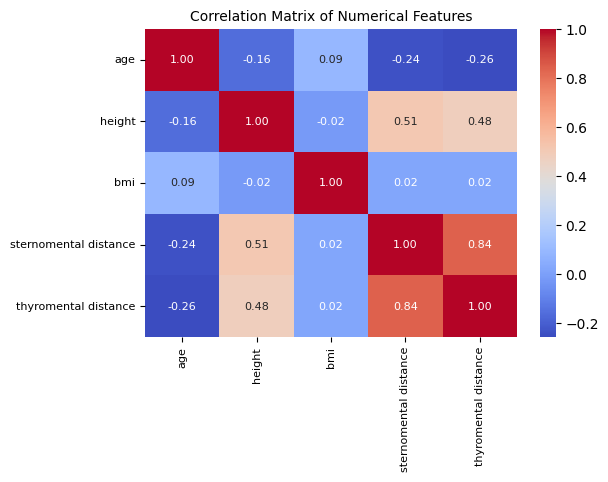

In [19]:
# prompt: Write a program to visualize the correlation in df_num features and keep fontsize of labels be 8

_=plt.figure(figsize=(6, 4))
_=sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
_=plt.title('Correlation Matrix of Numerical Features', fontsize=10)
_=plt.xticks(fontsize=8)
_=plt.yticks(fontsize=8)
_=plt.show()


<Axes: xlabel='sternomental distance', ylabel='age'>

<Axes: xlabel='sternomental distance', ylabel='age'>

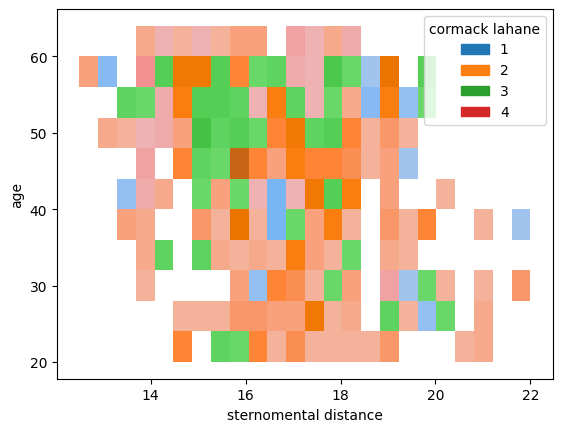

In [20]:
sns.histplot(df_num, x="sternomental distance", y="age")
sns.histplot(df, x="sternomental distance", y="age", hue = 'cormack lahane')


In [21]:
sum(df['thyromental distance'].notna() > 60)

0

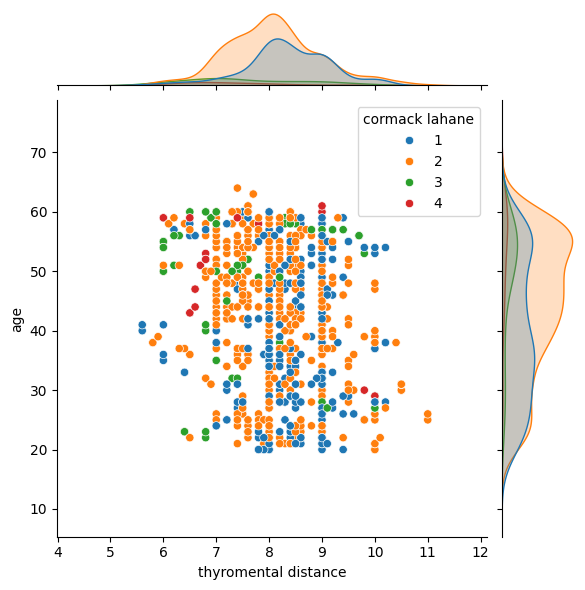

In [22]:
dx = df[df['thyromental distance'] < 60]
sns.jointplot(data=dx, x="thyromental distance", y="age", hue = 'cormack lahane')

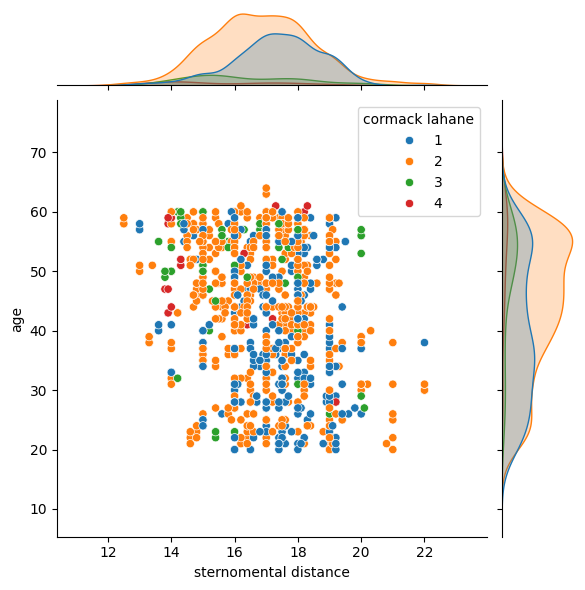

In [23]:
sns.jointplot(data=df, x="sternomental distance", y="age", hue = 'cormack lahane', palette= "tab10")

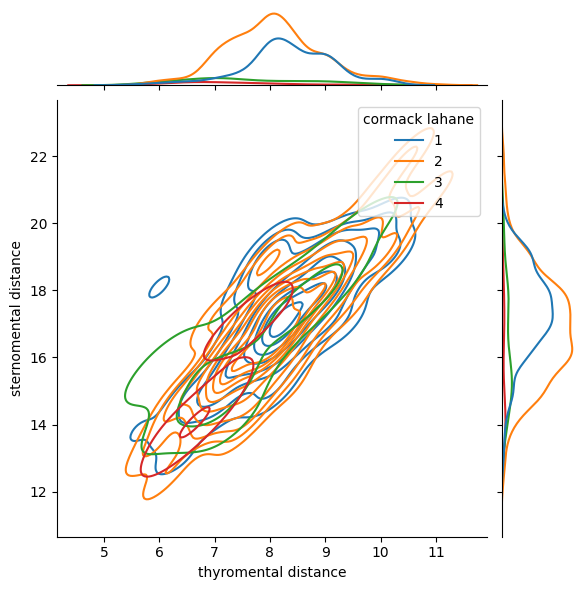

In [24]:
dx = df[df['thyromental distance'] < 60]
ax = sns.jointplot(data=dx, x="thyromental distance",
              y="sternomental distance",
              hue = 'cormack lahane',
              kind = "kde",
              palette= "tab10")




In [78]:
df.isna().sum()


age                        0
sex                        0
height                     0
subluxation of mandible    0
head and neck movement     0
buck teeth                 0
edentulous                 2
bmi                        0
sternomental distance      0
thyromental distance       0
mallampatti                0
mouth opening              0
cormack lahane             0
dtype: int64

In [ ]:
"""
# 1.3. Missing Data Treatment--amended

# 1.3.1 Impite Missing Categorical Data [Nominal | Ordinal] using Descriptive Statistics : Central Tendance (Mode)

# Dataset Used : df_cat_mde

si_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
si_cat_transformed = si_cat.fit_transform(df_cat)
df_cat = pd.DataFrame(si_cat_transformed, columns=df_cat.columns)
df_cat.head()
"""

"\n# 1.3. Missing Data Treatment--amended\n\n# 1.3.1 Impite Missing Categorical Data [Nominal | Ordinal] using Descriptive Statistics : Central Tendance (Mode)\n\n# Dataset Used : df_cat_mde\n\nsi_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')\nsi_cat_transformed = si_cat.fit_transform(df_cat)\ndf_cat = pd.DataFrame(si_cat_transformed, columns=df_cat.columns)\ndf_cat.head()\n"

In [ ]:
"""
from sklearn.impute import SimpleImputer

# 1.3.2.1 Impute missing Non-categorical data using descriptive statistical: central tendency
# Dataset used: df_noncat_mde

# Create a SimpleImputer with the 'most_frequent' strategy
si_noncat = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit and transform the data
si_noncat_transformed = si_noncat.fit_transform(df_noncat)
df_noncat = pd.DataFrame(si_noncat_transformed, columns=df_noncat.columns)
df_noncat.head()
"""

"\nfrom sklearn.impute import SimpleImputer\n\n# 1.3.2.1 Impute missing Non-categorical data using descriptive statistical: central tendency\n# Dataset used: df_noncat_mde\n\n# Create a SimpleImputer with the 'most_frequent' strategy\nsi_noncat = SimpleImputer(missing_values=np.nan, strategy='median')\n\n# Fit and transform the data\nsi_noncat_transformed = si_noncat.fit_transform(df_noncat)\ndf_noncat = pd.DataFrame(si_noncat_transformed, columns=df_noncat.columns)\ndf_noncat.head()\n"

"age", "height", "bmi", "sternomental distance", "thyromental distance"

In [ ]:
"""
df_ppd = df_noncat.join(df_cat)
df_ppd.head()
df_ppd.to_csv('/gdrive/MyDrive/Colab_data_files/drHarshVardhan/df_ppd.csv', index=False)
df_ppd.shape
df_ppd.info()
"""

"\ndf_ppd = df_noncat.join(df_cat)\ndf_ppd.head()\ndf_ppd.to_csv('/gdrive/MyDrive/Colab_data_files/drHarshVardhan/df_ppd.csv', index=False)\ndf_ppd.shape\ndf_ppd.info()\n"

In [ ]:
"""
No preprocessing to OHE
"""

'\nNo preprocessing to OHE\n'

# Random Forest

In [79]:
df_ppd = df

In [80]:
y = df_ppd.pop('cormack lahane')
X = df_ppd
#y = df_ppd['cormack lahane']


In [81]:
y.dtypes

CategoricalDtype(categories=[0, 1, 2, 3], ordered=False, categories_dtype=int64)

In [ ]:
# skip skip
le = LabelEncoder()
y = le.fit_transform(y)

In [82]:
# Splitting the dataset into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [31]:


# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train,y_train)
# Accuracy score
rf_classifier.score(X_test, y_test)

RandomForestClassifier(random_state=42)

0.865

In [32]:
# Calculate the train and test scores
train_score = rf_classifier.score(X_train,y_train)
test_score = rf_classifier.score(X_test,y_test)

# Print the train and test scores
print("Train Score {:.2f} & Test Score {:.2f}".format(train_score, test_score))

Train Score 1.00 & Test Score 0.86


In [33]:
rf_predictions = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("\n Random Forest Accuracy:", rf_accuracy)


 Random Forest Accuracy: 0.865


In [34]:
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.89      0.86        65
           2       0.87      0.92      0.90       112
           3       1.00      0.53      0.69        17
           4       1.00      0.50      0.67         6

    accuracy                           0.86       200
   macro avg       0.93      0.71      0.78       200
weighted avg       0.87      0.86      0.86       200



In [35]:
# Get feature importances
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame to store feature importance along with feature names
feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance"
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                    Feature  Importance
7                       bmi    0.185138
2                    height    0.160301
0                       age    0.149195
8     sternomental distance    0.139571
9      thyromental distance    0.137268
10              mallampatti    0.095205
5                buck teeth    0.034413
3   subluxation of mandible    0.032896
6                edentulous    0.024160
1                       sex    0.021955
4    head and neck movement    0.015676
11            mouth opening    0.004223


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None', ylabel='None'>

Text(0.5, 0, 'Feature Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Visualizing Important Features (Random Forest)')

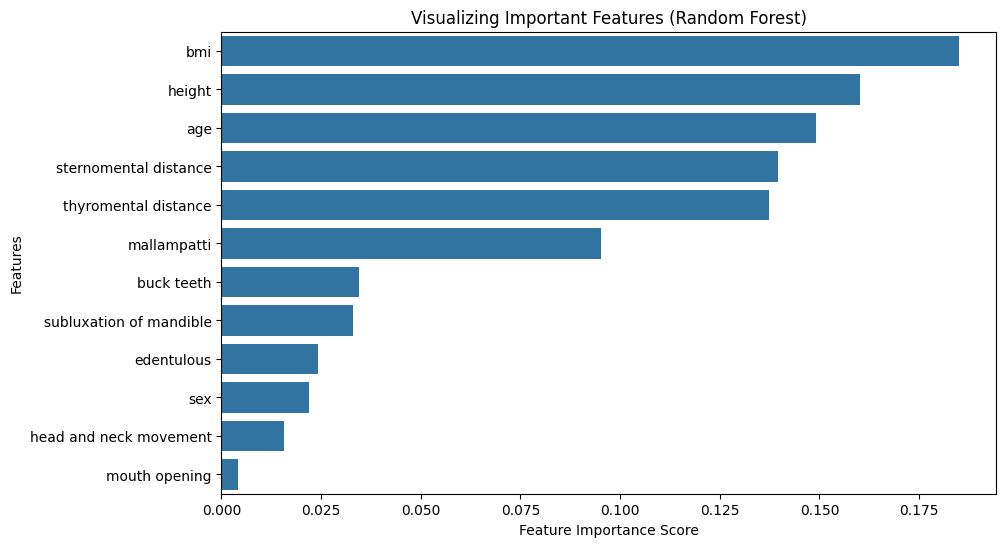

In [36]:
# Create a Series for feature importance with corresponding feature names
feature_imp = pd.Series(rf_classifier.feature_importances_, index=X_test.columns).sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (Random Forest)")
plt.show()

In [37]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_classifier, X_test, y_test,
                           n_repeats=40,
                           random_state=0)



In [38]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_ppd.columns[i]:<13}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

mallampatti  0.148 +/- 0.019
age          0.106 +/- 0.022
bmi          0.097 +/- 0.015
height       0.081 +/- 0.018
thyromental distance0.071 +/- 0.013
sternomental distance0.071 +/- 0.015
buck teeth   0.040 +/- 0.011
sex          0.027 +/- 0.011
edentulous   0.016 +/- 0.007


In [39]:
# REf: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
    # renamed to `tick_labels`. The following code handles this, but as a
    # scikit-learn user you probably can write simpler code by using `labels=...`
    # (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
    tick_labels_parameter_name = (
        "tick_labels"
            )
    tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

<Axes: >

Text(0.5, 0, 'Gini importance')

<Axes: >

Text(0.5, 0, 'Decrease in accuracy score')

Text(0.5, 0.98, 'Impurity-based vs. permutation importances on multicollinear features (test set)')

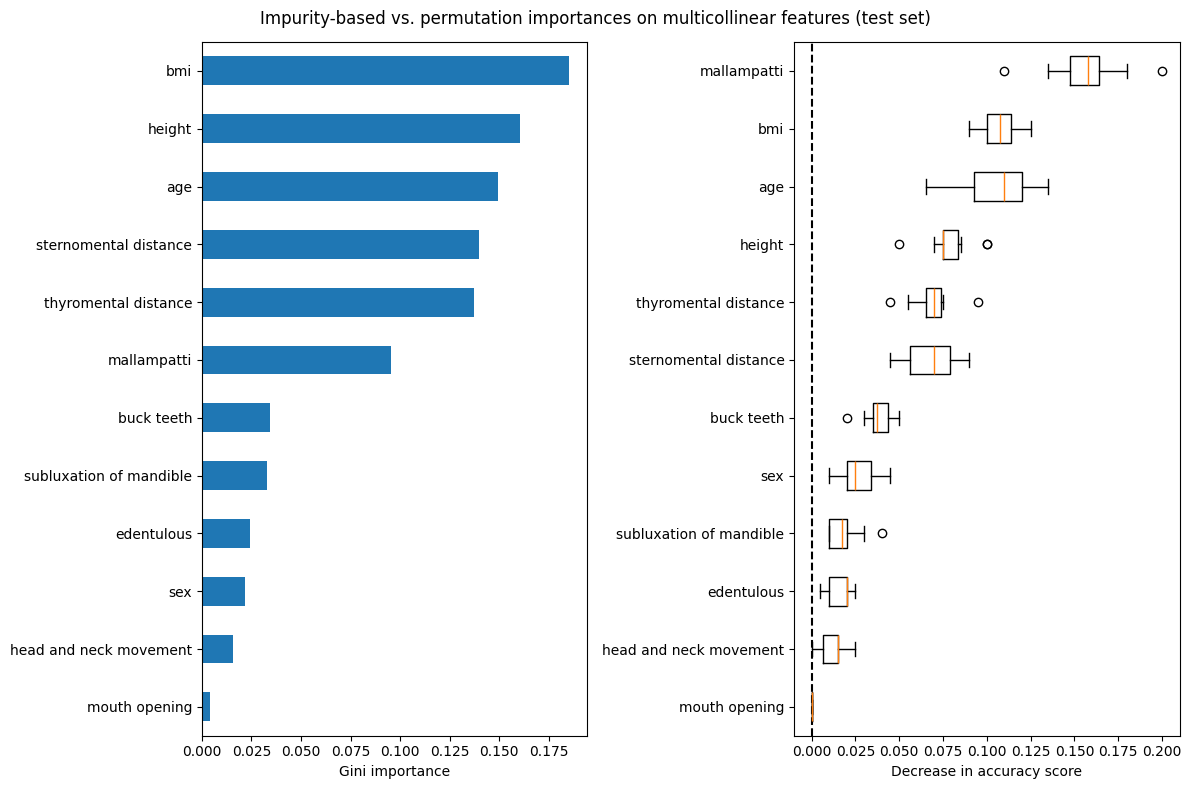

In [40]:
mdi_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(rf_classifier.feature_importances_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(rf_classifier, X_test, y_test, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (test set)"
)
_ = fig.tight_layout()

In [41]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
from sklearn.inspection import permutation_importance
rt = permutation_importance(rf_classifier, X_train, y_train,
                           n_repeats=40,
                           random_state=0)

In [42]:
for i in rt.importances_mean.argsort()[::-1]:
    if rt.importances_mean[i] - 2 * rt.importances_std[i] > 0:
        print(f"{df_ppd.columns[i]:<13}"
              f"{rt.importances_mean[i]:.3f}"
              f" +/- {rt.importances_std[i]:.3f}")

mallampatti  0.166 +/- 0.011
age          0.139 +/- 0.010
bmi          0.094 +/- 0.008
thyromental distance0.081 +/- 0.007
sternomental distance0.075 +/- 0.006
height       0.073 +/- 0.006
buck teeth   0.030 +/- 0.004
sex          0.014 +/- 0.003
subluxation of mandible0.009 +/- 0.003
head and neck movement0.008 +/- 0.002
edentulous   0.008 +/- 0.002


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None', ylabel='None'>

Text(0.5, 0, 'Feature Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Visualizing Important Features (Random Forest)')

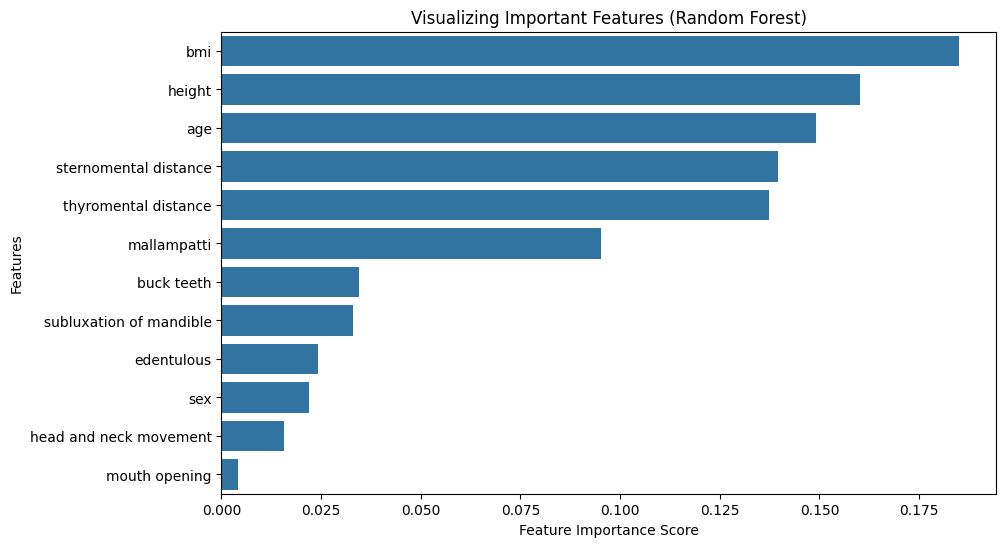

In [43]:
# Create a Series for feature importance with corresponding feature names
feature_imp = pd.Series(rf_classifier.feature_importances_, index=X_test.columns).sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (Random Forest)")
plt.show()

In [44]:

categorical_features = df_cat.columns[:-1]
hist_classifier = HistGradientBoostingClassifier(max_iter=400,
                                                 min_samples_leaf = 15,
                                                 l2_regularization = 10,
                                                 categorical_features = 'from_dtype' ,
                                                 learning_rate = 0.1,
                                                 #class_weight = 'balanced'
                                                 ).fit(X_train, y_train)



hist_classifier.score(X_test, y_test)


0.895

In [45]:
scores = cross_val_score(hist_classifier, X, y, cv=5)
scores

array([0.92 , 0.925, 0.915, 0.895, 0.91 ])

In [46]:
X.shape
type(X)

(1000, 12)

pandas.core.frame.DataFrame

In [47]:
from sklearn.inspection import permutation_importance
rh = permutation_importance(hist_classifier, X_test, y_test,
                           n_repeats=30,
                           random_state=0)



In [48]:
for i in rh.importances_mean.argsort()[::-1]:
    if rh.importances_mean[i] - 2 * rh.importances_std[i] > 0:
        print(f"{df_ppd.columns[i]:<13}"
              f"{rh.importances_mean[i]:.3f}"
              f" +/- {rh.importances_std[i]:.3f}")

bmi          0.170 +/- 0.020
mallampatti  0.154 +/- 0.022
height       0.134 +/- 0.015
age          0.108 +/- 0.017
thyromental distance0.107 +/- 0.017
sternomental distance0.085 +/- 0.016
buck teeth   0.031 +/- 0.009
sex          0.026 +/- 0.009
head and neck movement0.021 +/- 0.005


In [49]:
df.columns

Index(['age', 'sex', 'height', 'subluxation of mandible',
       'head and neck movement', 'buck teeth', 'edentulous', 'bmi',
       'sternomental distance', 'thyromental distance', 'mallampatti',
       'mouth opening'],
      dtype='object')

In [52]:
%%time
# prompt: For the dataset df, and target column 'cormack lahane' write code for stratified k fold with 5 splits

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import time

# Assuming X and y are defined as in your previous code
# X = df_ppd.drop('cormack lahane', axis=1)
# y = df_ppd['cormack lahane']

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)

hist_classifier = HistGradientBoostingClassifier(max_iter=400,
                                                 min_samples_leaf = 15,
                                                 #l2_regularization = 10,
                                                 categorical_features = 'from_dtype' ,
                                                 learning_rate = 0.1,
                                                 class_weight = 'balanced'
                                                 )

start = time.time()
list_accu_stratified = []
count = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("=======")
    print("fold:", count ) ; count = count +1
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
    hist_classifier.fit(X_train, y_train)
    print("Accuracy:", hist_classifier.score(X_test, y_test))
    list_accu_stratified.append(hist_classifier.score(X_test, y_test))

print("========")
print("Overall Accuracy:", np.mean(list_accu_stratified))
print("========")


fold: 1
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.875
fold: 2
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.87
fold: 3
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.91
fold: 4
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.895
fold: 5
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.905
Overall Accuracy: 0.891
CPU times: user 11.8 s, sys: 434 ms, total: 12.3 s
Wall time: 13 s


## Extratrees

In [53]:
X.dtypes
y.dtypes

age                           int64
sex                        category
height                        int64
subluxation of mandible    category
head and neck movement     category
buck teeth                 category
edentulous                 category
bmi                         float64
sternomental distance       float64
thyromental distance        float64
mallampatti                category
mouth opening              category
dtype: object

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False, categories_dtype=int64)

In [54]:

%%time

y= pd.DataFrame(y, columns = ['cormack lahane'])


# prompt: For the dataset df, and target column 'cormack lahane' write code for stratified k fold with 5 splits


# Assuming X and y are defined as in your previous code
# X = df_ppd.drop('cormack lahane', axis=1)
# y = df_ppd['cormack lahane']

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)


clf = ExtraTreesClassifier(n_estimators=100,
                           max_depth=None,
                           min_samples_split=2)



start = time.time()
list_accu_stratified = []
count = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("=======")
    print("fold:", count ) ; count = count +1
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
    clf.fit(X_train, y_train)
    print("Accuracy:", clf.score(X_test, y_test))
    list_accu_stratified.append(clf.score(X_test, y_test))

print("========")
print("Overall Accuracy:", np.mean(list_accu_stratified))
print("========")


fold: 1
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.915
fold: 2
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.895
fold: 3
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.93
fold: 4
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.9
fold: 5
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.885
Overall Accuracy: 0.905
CPU times: user 1.1 s, sys: 9.03 ms, total: 1.11 s
Wall time: 1.11 s


In [55]:

%%time

#y= pd.DataFrame(y, columns = ['cormack lahane'])
#y.head()

# prompt: For the dataset df, and target column 'cormack lahane' write code for stratified k fold with 5 splits
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import time


#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


clf = ExtraTreesClassifier(n_estimators=100,
                           max_depth=None,
                           min_samples_split=2)

total_acc_list = []
count = 1
for i in range(50):
  list_accu_stratified = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)
  #count = 1
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      clf.fit(X_train, y_train)
      print("Accuracy:", clf.score(X_test, y_test))
      list_accu_stratified.append(clf.score(X_test, y_test))

  total_acc_list.append(list_accu_stratified)





fold: 1
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.92
fold: 2
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.9
fold: 3
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.92
fold: 4
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.9
fold: 5
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.91
fold: 6
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.915
fold: 7
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.89
fold: 8
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.91
fold: 9
X_train shape: (800, 12) y_train shape: (

In [56]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.9058
Std deviation of accuracy: 0.013984276885130684


<Axes: xlabel='accuracy'>

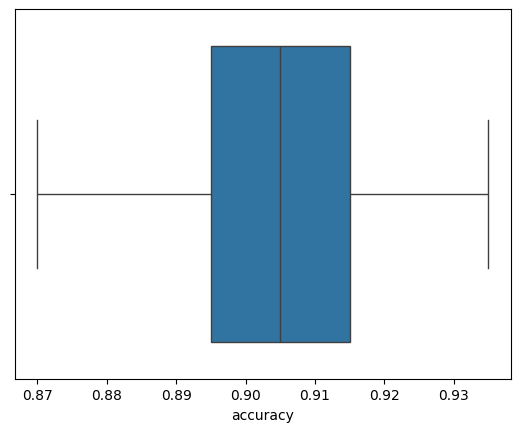

In [57]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


<Axes: xlabel='accuracy'>

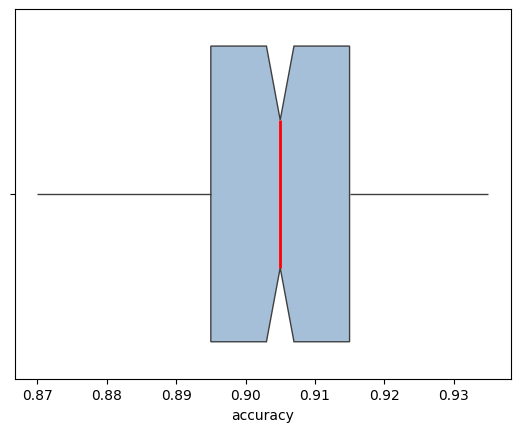

In [58]:
sns.boxplot(
            data=acc, x="accuracy",
            notch=True, showcaps=False,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

In [59]:
X.columns

Index(['age', 'sex', 'height', 'subluxation of mandible',
       'head and neck movement', 'buck teeth', 'edentulous', 'bmi',
       'sternomental distance', 'thyromental distance', 'mallampatti',
       'mouth opening'],
      dtype='object')

In [68]:

%%time

#y= pd.DataFrame(y, columns = ['cormack lahane'])
#y.head()

# prompt: For the dataset df, and target column 'cormack lahane' write code for stratified k fold with 5 splits
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import time


#skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


clf = ExtraTreesClassifier(n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           class_weight = 'balanced',
                           ccp_alpha = 0.0005)

total_acc_list = []
count = 1
for i in range(50):
  list_accu_stratified = []
  #count = 1
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      clf.fit(X_train, y_train)
      print("Accuracy:", clf.score(X_test, y_test))
      list_accu_stratified.append(clf.score(X_test, y_test))

  total_acc_list.append(list_accu_stratified)





fold: 1
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.925
fold: 2
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.885
fold: 3
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.92
fold: 4
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.91
fold: 5
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.89
fold: 6
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.925
fold: 7
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.89
fold: 8
X_train shape: (800, 12) y_train shape: (800, 1)
X_test shape: (200, 12) y_test shape: (200, 1)
Accuracy: 0.925
fold: 9
X_train shape: (800, 12) y_train sha

In [69]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.90536
Std deviation of accuracy: 0.016207109551058148


<Axes: xlabel='accuracy'>

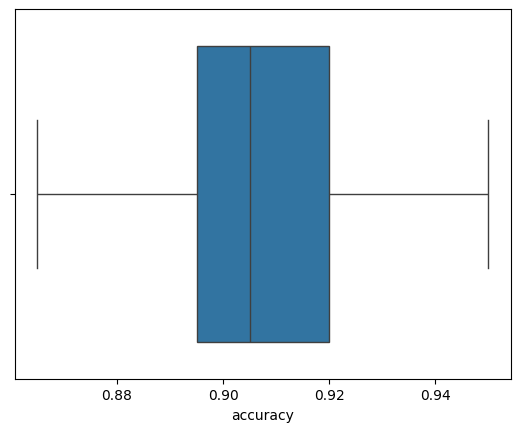

In [70]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=40,
                           random_state=0)



In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_ppd.columns[i]:<13}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

mallampatti  0.170 +/- 0.022
age          0.128 +/- 0.020
bmi          0.112 +/- 0.019
thyromental distance0.093 +/- 0.014
sternomental distance0.079 +/- 0.012
height       0.077 +/- 0.015
buck teeth   0.045 +/- 0.011
subluxation of mandible0.023 +/- 0.006
edentulous   0.020 +/- 0.006
head and neck movement0.016 +/- 0.007


In [90]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
bst = XGBClassifier(n_estimators=200,
                    max_depth=7,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    enable_categorical = True)
# fit model
bst.fit(X_train, y_train)
# make predictions
xgb_preds = bst.predict(X_test)
# Calculate the accuracy of the classifier
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print("\n XGBoost:", xgb_accuracy)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


 XGBoost: 0.895


In [91]:

%%time

#y= pd.DataFrame(y, columns = ['cormack lahane'])
#y.head()

# prompt: For the dataset df, and target column 'cormack lahane' write code for stratified k fold with 5 splits
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import time


#skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


clf = XGBClassifier(tree_method="hist",
                    n_estimators=200,
                    max_depth=7,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    enable_categorical = True)

total_acc_list = []
count = 1
for i in range(50):
  list_accu_stratified = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)
  #count = 1
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      clf.fit(X_train, y_train)
      print("Accuracy:", clf.score(X_test, y_test))
      list_accu_stratified.append(clf.score(X_test, y_test))

  total_acc_list.append(list_accu_stratified)





fold: 1
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.89
fold: 2
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.855
fold: 3
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
fold: 4
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.885
fold: 5
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
fold: 6
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.89
fold: 7
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.855
fold: 8
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
fold: 9
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12

In [93]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.878
Std deviation of accuracy: 0.012083045973594584


<Axes: xlabel='accuracy'>

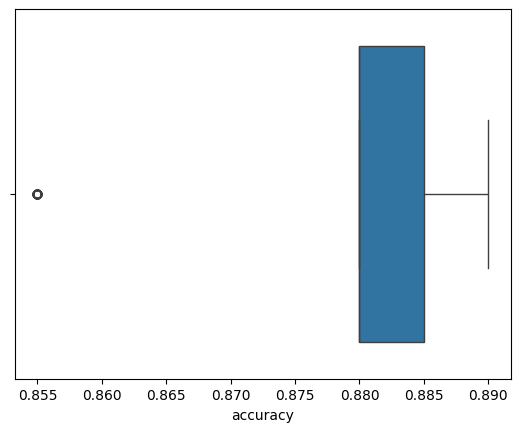

In [94]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


## Voting classifier

In [109]:
from sklearn.ensemble import  VotingClassifier



xgb_clf = XGBClassifier(tree_method="hist",
                        n_estimators=200,
                        max_depth=7,
                        learning_rate=0.1,
                        objective='binary:logistic',
                        enable_categorical = True
                        )

extra_clf = ExtraTreesClassifier(n_estimators=150,
                                max_depth=None,
                                min_samples_split=2,
                                #class_weight = 'balanced',
                                #ccp_alpha = 0.0005
                                 )

hist_classifier = HistGradientBoostingClassifier(max_iter=400,
                                                 min_samples_leaf = 15,
                                                 #l2_regularization = 10,
                                                 categorical_features = 'from_dtype' ,
                                                 learning_rate = 0.1,
                                                 class_weight = 'balanced'
                                                 )

eclf = VotingClassifier(estimators=[('xgb', xgb_clf), ('hist', hist_classifier), ('extra', extra_clf)],
                         voting='soft')



total_acc_list = []
count = 1
for i in range(50):
  list_accu_stratified = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      print("Accuracy:", eclf.score(X_test, y_test))
      list_accu_stratified.append(clf.score(X_test, y_test))

  total_acc_list.append(list_accu_stratified)



fold: 1
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 2
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 3
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 4
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 5
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 6
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 7
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 8
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 9
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.935
fold: 10
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 11
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 12
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 13
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 14
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.845
fold: 15
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 16
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 17
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 18
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 19
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 20
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 21
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 22
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 23
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 24
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 25
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 26
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 27
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 28
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.94
fold: 29
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 30
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.85
fold: 31
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 32
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 33
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 34
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 35
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 36
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 37
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 38
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 39
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 40
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 41
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 42
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 43
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.94
fold: 44
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 45
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 46
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 47
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 48
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 49
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 50
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 51
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 52
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 53
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 54
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 55
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 56
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 57
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 58
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 59
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 60
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 61
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.935
fold: 62
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 63
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 64
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 65
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 66
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 67
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 68
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 69
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 70
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 71
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 72
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 73
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 74
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 75
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 76
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 77
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 78
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 79
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 80
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 81
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 82
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 83
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 84
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 85
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 86
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 87
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 88
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 89
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 90
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 91
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 92
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 93
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 94
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 95
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 96
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 97
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 98
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 99
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 100
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.925
fold: 101
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 102
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 103
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 104
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 105
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 106
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.84
fold: 107
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 108
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 109
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 110
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 111
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 112
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 113
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 114
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.935
fold: 115
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 116
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 117
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 118
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 119
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 120
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 121
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 122
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 123
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 124
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 125
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 126
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 127
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 128
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 129
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 130
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 131
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 132
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 133
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 134
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 135
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 136
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 137
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.925
fold: 138
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 139
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.815
fold: 140
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 141
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 142
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 143
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 144
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 145
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 146
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.85
fold: 147
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 148
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 149
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 150
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 151
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 152
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 153
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 154
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 155
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 156
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.935
fold: 157
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 158
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 159
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 160
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 161
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 162
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 163
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 164
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 165
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 166
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 167
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 168
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 169
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 170
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 171
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 172
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 173
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 174
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 175
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 176
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 177
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 178
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 179
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 180
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 181
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 182
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 183
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.845
fold: 184
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.92
fold: 185
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 186
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 187
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 188
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 189
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 190
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 191
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 192
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 193
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 194
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 195
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 196
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 197
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 198
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.935
fold: 199
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 200
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.925
fold: 201
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 202
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.835
fold: 203
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.845
fold: 204
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 205
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 206
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.925
fold: 207
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 208
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 209
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 210
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.86
fold: 211
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 212
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 213
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 214
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 215
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 216
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 217
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 218
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 219
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 220
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 221
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.845
fold: 222
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 223
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 224
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.855
fold: 225
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.915
fold: 226
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 227
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.895
fold: 228
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.885
fold: 229
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 230
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 231
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.865
fold: 232
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 233
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.95
fold: 234
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 235
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 236
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.91
fold: 237
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 238
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.93
fold: 239
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 240
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 241
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 242
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.9
fold: 243
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.875
fold: 244
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 245
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.925
fold: 246
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87
fold: 247
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.89
fold: 248
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.905
fold: 249
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.88
fold: 250
X_train shape: (800, 12) y_train shape: (800,)
X_test shape: (200, 12) y_test shape: (200,)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('hist',
                              HistGradientBoostingClassifier(class_weight='balanced',
                                                             max_iter=400,
                                                             min_samples_leaf=15)),
                             ('extra', ExtraTreesClassifier(n_estimators=150))],
                 voting='soft')

Accuracy: 0.87


In [110]:
total_acc_list
IIndattempt = total_acc_list

[[0.97, 0.985, 0.98, 0.96, 0.975],
 [0.98, 0.965, 0.975, 0.97, 0.98],
 [0.975, 0.965, 0.99, 0.955, 0.985],
 [0.975, 0.98, 0.975, 0.99, 0.95],
 [0.985, 0.975, 0.965, 0.975, 0.97],
 [0.98, 0.97, 0.975, 0.98, 0.965],
 [0.97, 0.99, 0.975, 0.965, 0.97],
 [0.98, 0.975, 0.96, 0.97, 0.985],
 [0.975, 0.965, 0.96, 0.985, 0.985],
 [0.98, 0.965, 0.96, 0.985, 0.98],
 [0.97, 0.97, 0.965, 0.98, 0.985],
 [0.98, 0.965, 0.98, 0.98, 0.965],
 [0.97, 0.965, 0.975, 0.97, 0.99],
 [0.96, 0.965, 0.975, 0.97, 1.0],
 [0.97, 0.96, 0.985, 0.995, 0.96],
 [0.97, 0.975, 0.98, 0.97, 0.975],
 [0.97, 0.96, 0.98, 0.97, 0.99],
 [0.985, 0.975, 0.95, 0.97, 0.99],
 [0.985, 0.965, 0.975, 0.97, 0.975],
 [0.985, 0.97, 0.965, 0.98, 0.97],
 [0.985, 0.975, 0.955, 0.985, 0.97],
 [0.965, 0.98, 0.97, 0.985, 0.97],
 [0.98, 0.975, 0.96, 0.975, 0.98],
 [0.97, 0.985, 0.96, 0.965, 0.99],
 [0.98, 0.97, 0.96, 0.975, 0.985],
 [0.97, 0.975, 0.98, 0.98, 0.965],
 [0.98, 0.965, 0.965, 0.99, 0.97],
 [0.975, 0.97, 0.985, 0.96, 0.98],
 [0.975, 0.98

In [ ]:
Istattempt

In [111]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.974
Std deviation of accuracy: 0.010009995004993765


<Axes: xlabel='accuracy'>

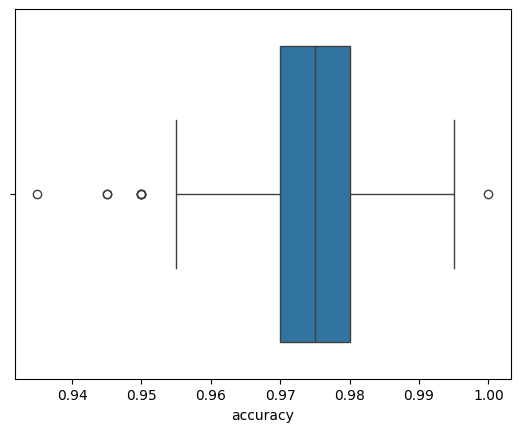

In [112]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


In [ ]:
###########